In [1]:
import numpy as np
from numpy import log2
from scipy import signal
import matplotlib.pyplot as plt

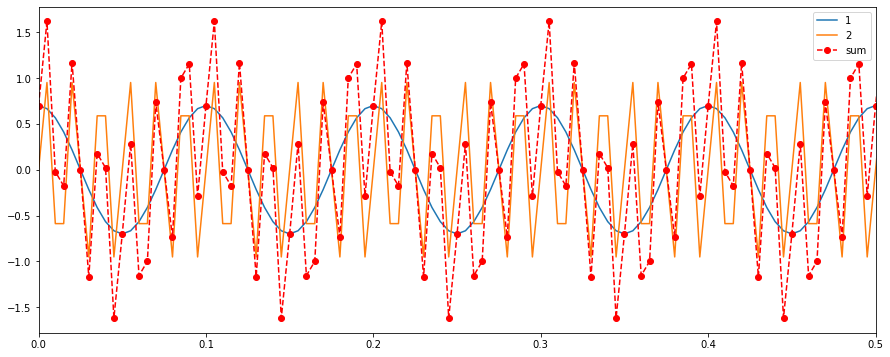

In [2]:
sample_rate = 200
nsamples = 400
freq_camp = sample_rate/nsamples
t = np.arange(nsamples) / sample_rate
y1 = 0.7*np.cos(2*np.pi*10*t)  # 10/400 = 0.025
y2 = np.sin(2*np.pi*60*t)  # 60/400 = 0.15 > 0.1

plt.figure(figsize=(15,6))
plt.plot(t,y1,label='1')
plt.plot(t,y2,label='2')
plt.plot(t,y2+y1,'r--o',label='sum')
plt.xlim(0,0.5)
plt.legend()

plt.show()

In [3]:
numtaps = 6
f = 0.03             #cut-off freq
taps= signal.firwin(numtaps, f)

print('coeff_1 = ', taps)


coeff_1 =  [0.02856076 0.14288273 0.32855651 0.32855651 0.14288273 0.02856076]


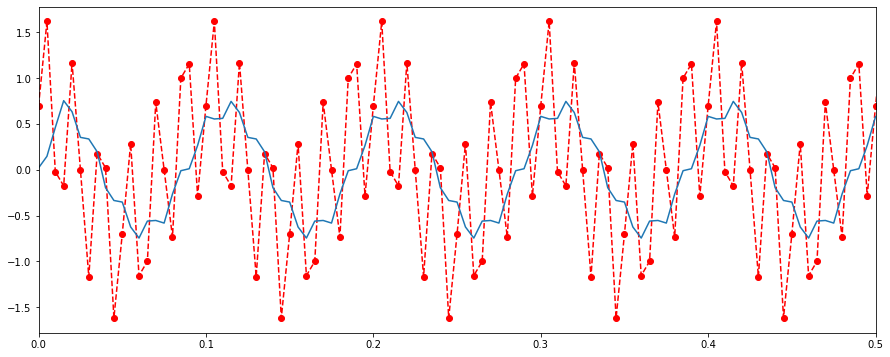

In [4]:
filtered_y = signal.lfilter(taps, 1, y1+y2)

plt.figure(figsize=(15,6))
plt.plot(t,y2+y1,'r--o',label='sum')
plt.plot(t,filtered_y )
plt.xlim(0,0.5)

plt.show()

In [5]:
def computeQ(y,taps):
    M = max(max(np.abs(taps)),max(np.abs(y)))
    Q = log2(127) - log2(M)
    return Q

def double_to_signed(a, Q):
    int_a = np.round(a*2**Q)
    signed = np.where(int_a >= 0, int_a, int_a + 256).astype(int)
    return signed
    
def signed_to_double(a,Q):
    signed = np.where(a >= 128, a-256, a)
    double_a = signed*2**(-Q)
    return double_a

def signed_to_double2(a,Q):
    signed = np.where(a >= 128, a-256, a)
    #new_Q = computeQ(a, np.array([0]))
    double_a = signed*2**(-Q) 
    return double_a

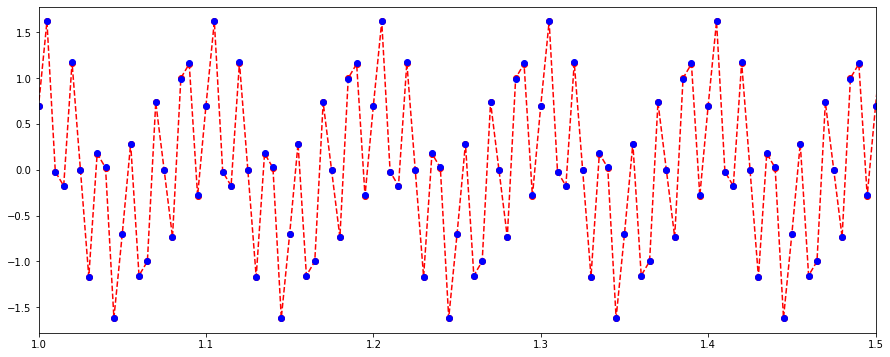

In [6]:
y = y1 + y2
Q = computeQ(y, taps)
signed = double_to_signed(y,Q)
double = signed_to_double(signed,Q)

plt.figure(figsize=(15,6))
plt.plot(t,y, 'r--o')
plt.plot(t,double, 'bo')
plt.xlim(1,1.5)
plt.show()

In [7]:
Q = computeQ(y, taps)
integer_taps = double_to_signed(taps, Q)
print([bin(i) for i in integer_taps])

['0b10', '0b1011', '0b11010', '0b11010', '0b1011', '0b10']


In [8]:
np.savetxt("signal.txt", y)

In [9]:
tmp = double_to_signed(y[:7], Q)
print([bin(i) for i in tmp])

['0b110111', '0b1111111', '0b11111110', '0b11110010', '0b1011100', '0b0', '0b10100100']


## find maximum

In [11]:
s_max = max(double_to_signed(y, Q))
t_max = max(double_to_signed(taps, Q))

mult = s_max * np.sum(double_to_signed(taps,Q)) 
print(bin(mult))

0b100110101100100


## comparison

(0, 0.5)

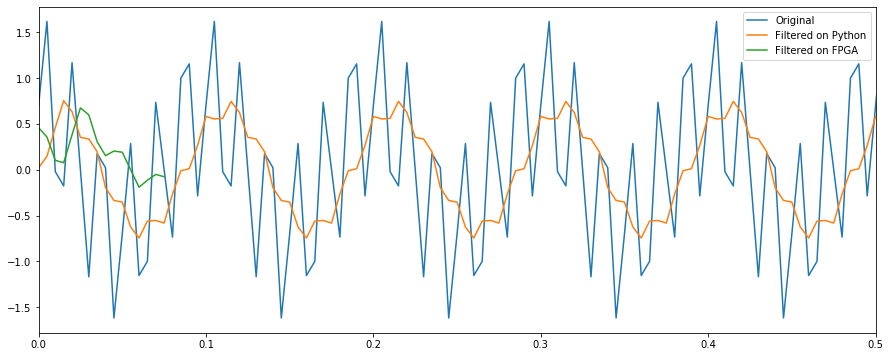

In [11]:
filtered_by_fpga = np.loadtxt("filtered_signal.txt")

plt.figure(figsize=(15,6))
plt.plot(t, y, label="Original")
plt.plot(t, filtered_y, label="Filtered on Python")
plt.plot(t[:16], filtered_by_fpga, label="Filtered on FPGA")
plt.legend()
plt.xlim(0, 0.5)

#filtered_y / filtered_by_fpga

In [ ]:
max_y = np.max(y)
print(max_y)

In [ ]:
arr = [0b0000000, 0b00000110, 0b000010110, 0b000100100, 0b000011110, 0b00010000, 0b00010000]
arr = np.array([ord(chr(a)) for a in arr])
sig1 = signed_to_double(arr, Q)
sig2 = signed_to_double(arr, Q-1)
sig3 = signed_to_double2(arr,Q) * max_y 


In [ ]:
sig3-filtered_y[:7]

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(t[:7], sig1, label="sig1")
plt.plot(t[:7], sig2, label="sig2")
plt.plot(t[:7], sig3, label="sig3")
plt.plot(t[:7], filtered_y[:7], label="python")
#plt.plot(t[:7], filtered_by_fpga[:7], label="fpga")
plt.legend()
plt.grid(True)

## Attempt for studying the approximation done

In [ ]:
series = np.linspace(-1, 1, 1001)
Q = computeQ(series, taps)
transformed = signed_to_double(double_to_signed(series, Q), Q)
plt.figure(figsize=(15,6))
plt.plot(series, series-transformed)
plt.xlim(-1, 0.5)

discrepancy = series - transformed
print(max(discrepancy), min(discrepancy))

disc_pos = discrepancy[discrepancy > 0]
plt.figure(figsize=(15,6))
plt.plot(series[discrepancy > 0], disc_pos)
plt.xlim(-1, 0.5)
print(max(disc_pos), min(disc_pos))